# A Deep Dive into Amazon Forecast 
<br>
<br>


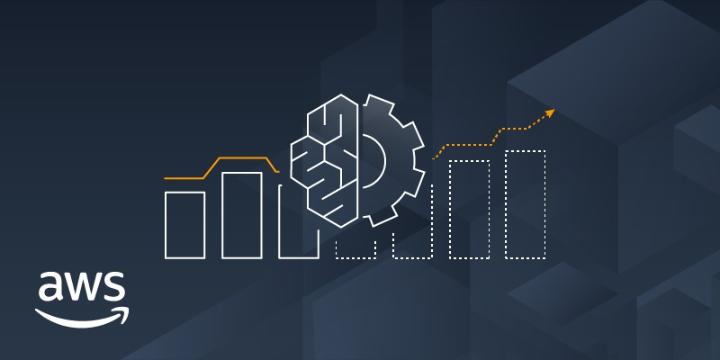

<br>
<br>

Amazon announced its fully managed time series forecasting service, Forecast at AWS Re:Invent last year. This year in August, it was made publically available, with the ability to train custom deep learning models without writing a single line of code or managing any infrastructure. ML-As-A-Service has become extremely popular in the last couple of years, because of their robustness, generalizability and low turnaround time in common business use cases. Amazon Forecast is particularly interesting because it steps up ML as a service model by providing the ability to train on customer's data rather than just relying on pre-trained models. 

Time series forecasting problems are still solved in a majority of companies through classic approaches like ARIMA and do not fall in the Big Data or Deep Learning radar. Even though companies have started hiring Deep Learning specialists, not every Data Scientist has the skills to train, tune and scale time series based deep networks like LSTMs which are effectively proven to handle large and multivariate datasets. Amazon Forecast, essentially boils down a complex Data Science problem into a fairly simple data ingestion pipeline. 

In this article, we explore Forecast from a technical standpoint along with a Jupter notebook, which can help advanced users to get familiar with all aspects of the service. Forecast assumes and requires no ML knowledge and so does this article, though some of it was required to put together the notebook! So if you are just starting with ML, you can give it a casual read and if you are an intermediate to advanced user, you can download and run the notebook. 

#### What are Time Series Problems
Time series forecasting is one of the oldest and most prevalent problems solved by Machine Learning. It refers to a prediction problem of an entity changing with time and also intuitively heavily dependent on time. We have, knowingly or otherwise applied time series in our daily lives - when we estimate traffic when leaving at a particular time, or average out something from its value last week. Time series, as an ML domain, has a rich and established literature yet it remains an outsider when compared to its popular cousins like NLP and Image Processing. To understand the basic difference between a time series forecast and other classic ML problems, time series problems assume that time is the only dominant factor in predicting something - that is time related trends and seasonality are sufficient to accurately predict your target value. One key difference to understand is that while classic ML problems like Regression and Classification assume that two data points are isolated and independent; Time series models are auto-regressive in nature - i.e. the target value to predict (e.g. future Sales) is derived from its previous values in time. (E.g. Sales last week or Sales last holiday season). Also note that time series models require to be re-trained much more regularly compared to other ML models like image classifiers or language translators. 


In [ ]:
import boto3
import pandas as pd 
import numpy as np 
import warnings 
from time import sleep 
warnings.filterwarnings('ignore')
%matplotlib inline 

### Dataset 
To understand Forecast's features, we chose this dataset [dataset](https://www.kaggle.com/c/demand-forecasting-kernels-only/overview) which is a relatively simple and clean dataset to explore different time series techniques. 
We are given 5 years of store-item sales data, for 50 different items at 10 different stores. Forecast features 5 algorithms namely - ARIMA, ETS, NPTS, DeepAR_Plus and Prophet. Apart from manually choosing among these algorithms, Forecast comes with Auto ML functionality which will evaluate all  algorithms and choose the one that performs best for your dataset. By the end of this article, we will try to ponder upon questions like - Does Deep Learning always work better than other methods like ARIMA, Is just choosing Auto ML always the best choice, How much data processing is required, Do we have to make our datasets stationary, How to incorporate store or location information etc.  
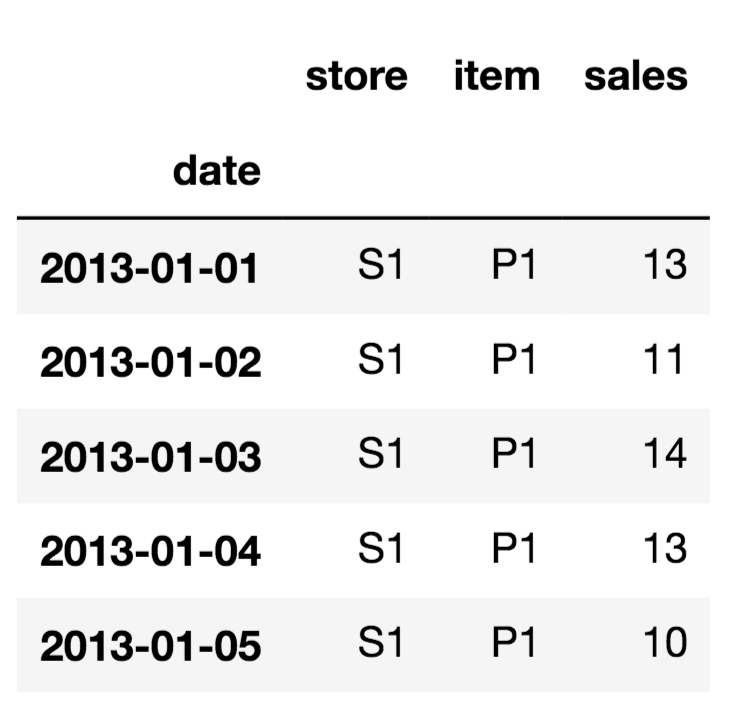


We observe that the dataset has 900k rows with three columns. Here, S1 implies Store_One and P1 implies Product_One. The sales column can be assumed to be the units sold for that product on a particular day. The date column includes each day from 2013 to 2017. In the interest of saving some training time we cut down on the dataset size from 5 years to 3 years. 
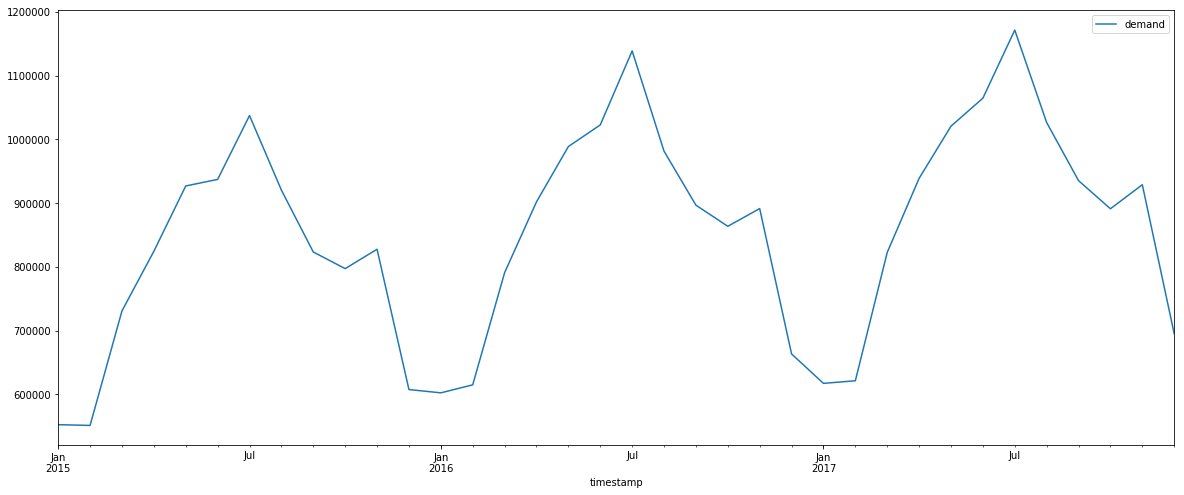


Also we group the dataset by monthly total sales and apply some seasonal decomposition on it which returns visual charts related to trends and seasonality in the entire dataset. We observe that there is a general upward trend and strong seasonality repeated every year.  

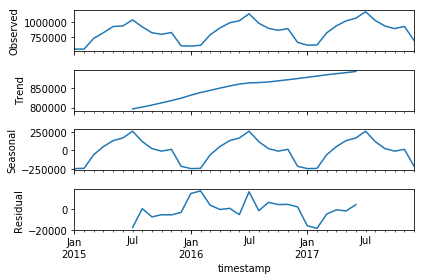

Forecast provides Test results related metrics after a predictor is trained. However, we keep one month's of data at the end of the time series to act as unseen data in the future for evaluation.


##### Adding indentifiers for Stores and Products

In [ ]:
df_daily_sales = pd.read_csv('daily_sales_data.csv',  parse_dates=True, index_col =0)
df_daily_sales['store'] = 'S' + df_daily_sales['store'].astype(str) 
df_daily_sales['item'] = 'P' + df_daily_sales['item'].astype(str)
df_daily_sales.head()


##### 900k Observations with 2 categorical and one target value. 

In [ ]:
df_daily_sales.shape

In [ ]:
df_daily_sales.index.min(), df_daily_sales.index.max(), df_daily_sales.index.nunique()

##### Filter and train-test split

In [ ]:
df_daily_sales = df_daily_sales.loc['2015-01-01':]
df_daily_sales.shape

In [ ]:
df_daily_sales.index.names = ['timestamp']
df_daily_sales.columns = ['location', 'item_id', 'demand']

In [ ]:
train_data = df_daily_sales.loc[:'2017-11-30']
test_data = df_daily_sales.loc['2017-12-01':]

In [ ]:
train_data.shape, test_data.shape

In [ ]:
train_data.tail()

##### Write to CSV and copy to S3 for Predictor training. 

In [ ]:
train_data.to_csv('train.csv', header=True)

In [ ]:
df_monthly_total_sales = df_daily_sales.resample('1M').sum()


##### Monthly sales across all stores and products

In [ ]:
df_monthly_total_sales.plot(figsize=(20,8), legend=True)

##### Analyze for seasonality and trend

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df_monthly_total_sales['demand'], freq=12, model='additive')
results.plot();

### Dataset Groups and Datasets

Next, we move on to using the Forecat APIs. This neat flow diagram from AWS's official blog shows all the steps involved in building your Forecast pipeline. 

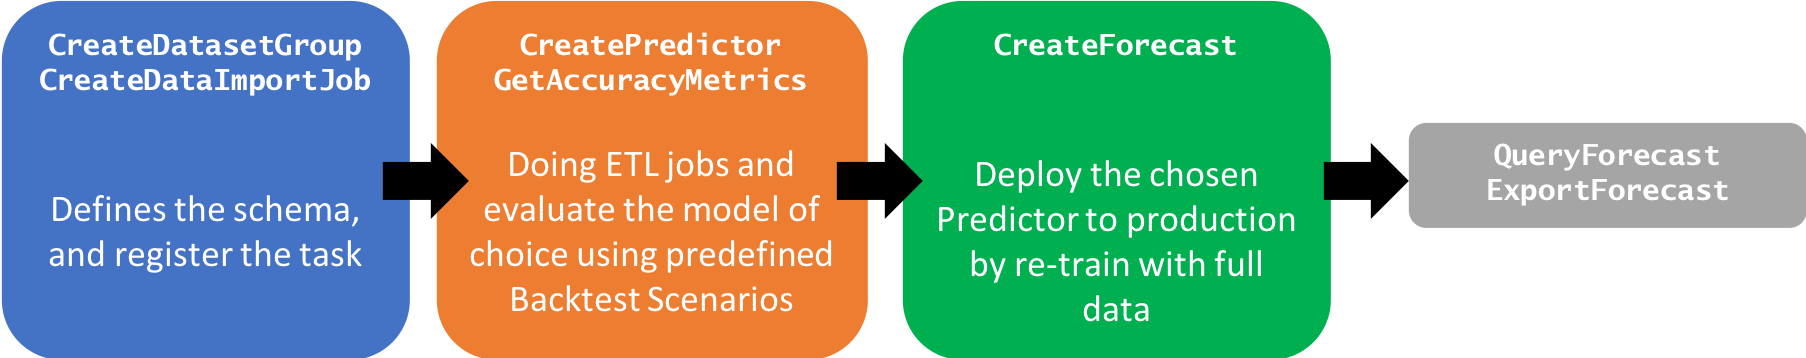

- We start by creating a Dataset group, followed by defining the schema for our target time series.
- We have followed the template for the Retail Domain which requires item_id and demand (sales) as a required field in the schema along with the timestamp. Note that we include the store (location) as a dimension in the schema. 
- We then create the target time series data set by triggering an import job. Forecast allows 3 types of datasets - Target, which is the primary dataset and has the timestamps; Item metadata and Related Time Series (Eg Competitor time series, Sales information from other cities, etc). 
- An import job needs to be triggered if there is an update to the data and we want that to be reflected in either the next training or a prediction request. 


Note that a S3 bucket and role with full access to Forecast are being used here which you might have to replace with your own resources. 



##### Copy training data to S3.  

In [ ]:
key='daily-sales-data/train.csv'
bucket_name = 'forecast-cloudwick'
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file("train.csv")

##### Create DataSet Group  

In [ ]:
forecast = boto3.client(service_name='forecast') 
forecastquery = boto3.client(service_name='forecastquery')
datasetGroupName = 'daily_sales_data'
create_dataset_group_response = forecast.create_dataset_group(DatasetGroupName=datasetGroupName,Domain="RETAIL")
datasetGroupArn = create_dataset_group_response['DatasetGroupArn']

##### Define schema for target time series. Retail template requires item_id, demand and timestamp.

In [ ]:
schema ={
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
       {
         "AttributeName":"location",
         "AttributeType":"string"
      }, 
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      }, 
      {
         "AttributeName":"demand",
         "AttributeType":"integer"
      }
      
   ]
}

##### Define dataset with Frequence and Timestamp format. 

In [ ]:
datasetName= 'daily_sales_store_item'
s3DataPath = "s3://"+bucket_name+"/"+key
DATASET_FREQUENCY = 'D'
TIMESTAMP_FORMAT = "yyyy-MM-dd"

In [ ]:
response=forecast.create_dataset(
                    Domain="RETAIL",
                    DatasetType='TARGET_TIME_SERIES',
                    DatasetName=datasetName,
                    DataFrequency=DATASET_FREQUENCY, 
                    Schema = schema
)

In [ ]:
datasetArn = response['DatasetArn']
forecast.describe_dataset(DatasetArn=datasetArn)

##### Update DatasetGroup with target Dataset.

In [ ]:
forecast.update_dataset_group(DatasetGroupArn=datasetGroupArn, DatasetArns=[datasetArn])

##### Create Data Import Job  

In [ ]:
role_arn = 'arn:aws:iam::****:role/ForecastRoleDemo'  #replace Forecast role arn. 

In [ ]:
datasetImportJobName = 'ds_target_import_job'
ds_import_job_response=forecast.create_dataset_import_job(DatasetImportJobName=datasetImportJobName,
                                                          DatasetArn=datasetArn,
                                                          DataSource= {
                                                              "S3Config" : {
                                                                 "Path":s3DataPath,
                                                                 "RoleArn": role_arn
                                                              } 
                                                          },
                                                          TimestampFormat=TIMESTAMP_FORMAT
                                                         )
ds_import_job_arn=ds_import_job_response['DatasetImportJobArn']
print(ds_import_job_arn)


while True:
    dataImportStatus = forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)['Status']
    print(dataImportStatus)
    if dataImportStatus != 'ACTIVE' and dataImportStatus != 'CREATE_FAILED':
        sleep(30)
    else:
        break

### 1. ARIMA
<br> 
Arima is one of the more matured algorithms in the time series community and often is considered the starting benchmark. 
#### - AR - Auto regression or regression model based on the relationship between current observation and previous observations. 

#### - I  - Integration -  Essentially makes the time series stationary by differencing observations. 
In a stationary time series, simply put, statistical components do not vary over time. This does not mean that the series in itself does not change over time, rather the way it changes itself does not change over time! If that is confusing, spend some time by searching image examples of stationary vs non stantionary series. For modeling, stationary is better than non stationary as it brings along independence between data points. This is a good [reference](https://stats.stackexchange.com/questions/19715/why-does-a-time-series-have-to-be-stationary) discussion thread for those who are curious. To keep things simple and focussed on Forecast, we did not perform any processing to make our series stationary. 

<br> 
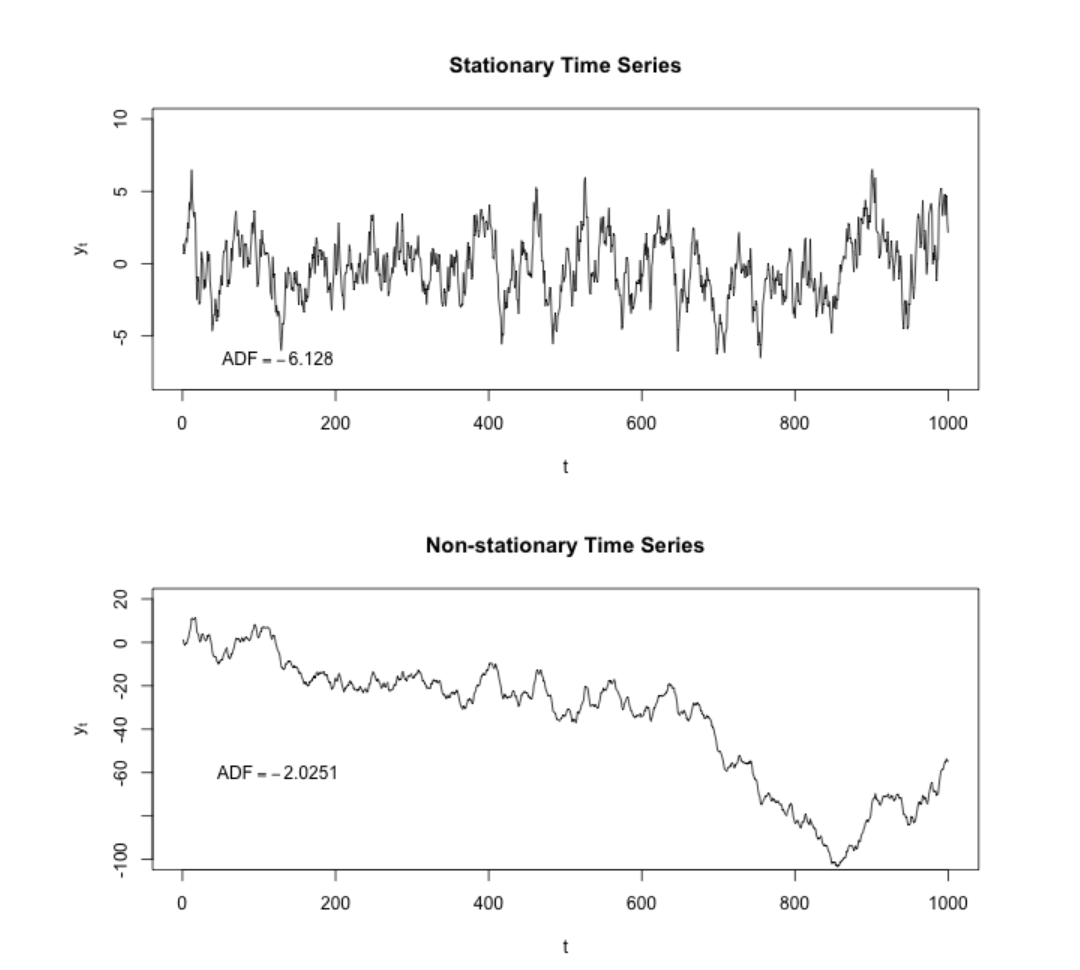
<br>

#### - MA - Moving Average -  Model that uses residual error from a moving average on lagged observations. 
<br>
<br>






##### Wrapper function to call create_predictor for multiple models. Also a helper function to check status of predictor training.  

In [ ]:
def create_predictor_( predictorName, algorithmArn):
    return forecast.create_predictor(PredictorName=predictorName, 
                                                      AlgorithmArn=algorithmArn,
                                                      ForecastHorizon=forecastHorizon,
                                                      PerformAutoML= False,
                                                      PerformHPO=False,
                                                      EvaluationParameters= {"NumberOfBacktestWindows": 1, 
                                                                             "BackTestWindowOffset": 31}, 
                                                      InputDataConfig= {"DatasetGroupArn": datasetGroupArn},
                                                      FeaturizationConfig= {"ForecastFrequency": "D", 
                                                                            "ForecastDimensions" : ['location'], 
                                                                            "Featurizations": 
                                                                            [
                                                                              {"AttributeName": "demand", 
                                                                               "FeaturizationPipeline": 
                                                                                [
                                                                                  {"FeaturizationMethodName": "filling", 
                                                                                   "FeaturizationMethodParameters": 
                                                                                    {"frontfill": "none", 
                                                                                     "middlefill": "zero", 
                                                                                     "backfill": "zero"}
                                                                                  }
                                                                                ]
                                                                              }
                                                                            ]
                                                                           }
                                                     )['PredictorArn']

def check_predictor_status(predictor_arn):
    while True:
        predictorStatus = forecast.describe_predictor(PredictorArn=predictor_arn)['Status']
        print(predictorStatus)
    if predictorStatus != 'ACTIVE' and predictorStatus != 'CREATE_FAILED':
        sleep(30)
    else:
        break

##### Set horizon, here we set it to one month - same as our testing data. 

In [ ]:
forecastHorizon = 31

In [ ]:
%%time
predictor_arn_arima = create_predictor_('predictor_arima','arn:aws:forecast:::algorithm/ARIMA')
check_predictor_status(predictor_arn_arima)

### Prophet

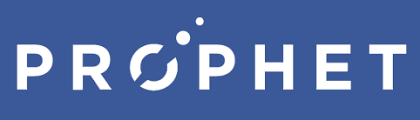

Prophet is an open source library published by Facebook and made public in mid 2017. In the last two years it has made it drastically easier to train time series models. It is based on simple, intuitive and decomposable [TREND, SEASONALITY, HOLIDAYS] models. According to their github description - it is an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.`

In [ ]:
%%time
predictor_arn_prophet = create_predictor_('predictor_prophet','arn:aws:forecast:::algorithm/Prophet')
check_predictor_status(predictor_arn_prophet)

### 3. DeepAR (Plus)
DeepAR stands for Deep Auto Regressive model, trained as a single model jointly over all of the time series using Recurrent Nueral Networks. Classical forecasting methods, such as ARIMA, fit a single model to each individual time series and then use that to extrapolate the time series into the future. When your dataset contains hundreds of related time series, for instance different products, server loads, and requests for webpages, DeepAR outperforms the standard ARIMA and ETS methods.  

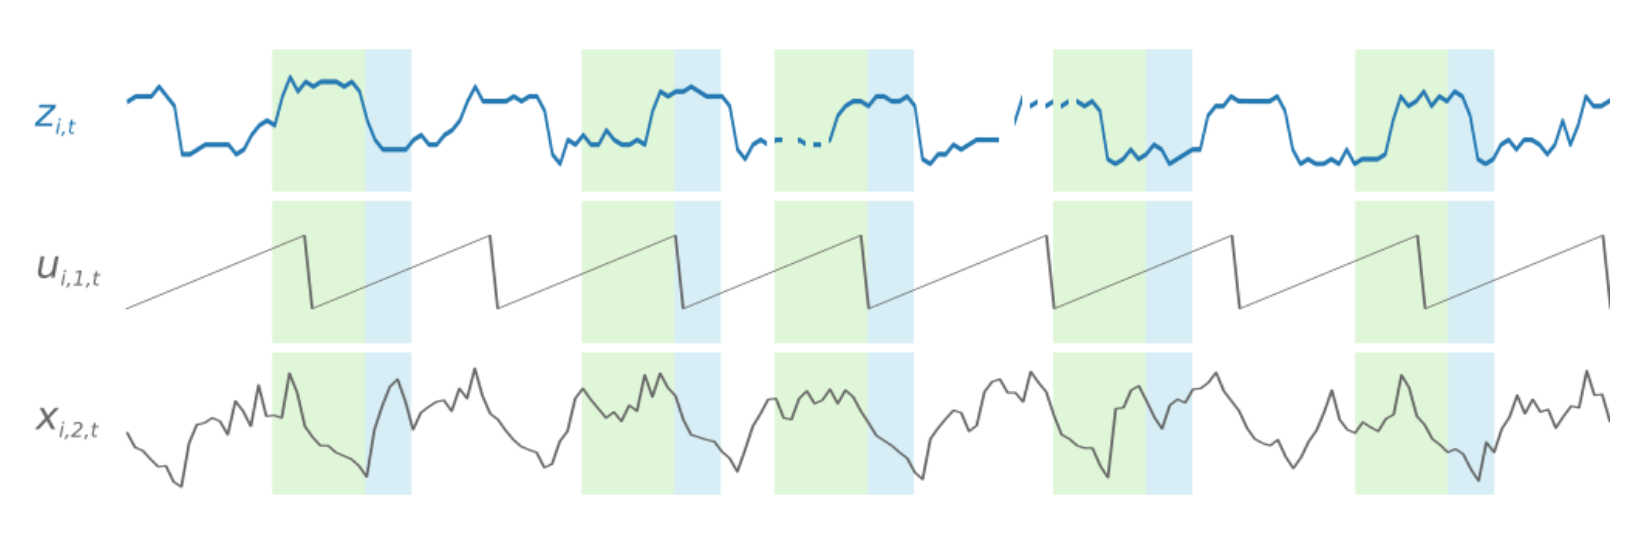

DeepAR was introduced last year as a SageMaker built in algorithm and has helped us to work with customers to deploy DeepAR models to production in a streamlined manner compared to training and iterating over different RNNs from scratch, not to mention the billing from forgeting to shut down GPUs.  DeepAR being available as a Managed service with the capability of comparing it with other standard models it helps solve the Deep vs Shallow discussions within your team right at the start of the use case. It also makes your pipeline robust for the future in case you are expecting an substantial increase in your data volume. We are not exactly sure about what the Plus in DeepAR stands for the Forecast offering, probably the auto hyperparameter tuning feature - which is definitely a plus point! 

In [ ]:
%%time
predictor_arn_deepar = create_predictor_('predictor_deepar','arn:aws:forecast:::algorithm/Deep_AR_Plus')
check_predictor_status(predictor_arn_deepar)

In [ ]:
%%time
predictor_arn_automl=forecast.create_predictor(PredictorName='predictor_automl', 
                                                  ForecastHorizon=forecastHorizon,
                                                  PerformAutoML=True,
                                                  PerformHPO=False,
                                                  EvaluationParameters= {"NumberOfBacktestWindows": 1, 
                                                                             "BackTestWindowOffset": 31}, 
                                                      InputDataConfig= {"DatasetGroupArn": datasetGroupArn},
                                                      FeaturizationConfig= {"ForecastFrequency": "D", 
                                                                            "ForecastDimensions" : ['location'], 
                                                                            "Featurizations": 
                                                                            [
                                                                              {"AttributeName": "demand", 
                                                                               "FeaturizationPipeline": 
                                                                                [
                                                                                  {"FeaturizationMethodName": "filling", 
                                                                                   "FeaturizationMethodParameters": 
                                                                                    {"frontfill": "none", 
                                                                                     "middlefill": "zero", 
                                                                                     "backfill": "zero"}
                                                                                  }
                                                                                ]
                                                                              }
                                                                            ]
                                                                           }
                                                     )['PredictorArn']

check_predictor_status(predictor_arn_automl)

##### Create Forecast using active Predictors.

In [ ]:
forecastArn_arima = create_forecast_response=forecast.create_forecast(ForecastName='forecast_arima',PredictorArn=predictor_arn_arima)['ForecastArn']
forecastArn_prophet = create_forecast_response=forecast.create_forecast(ForecastName='forecast_prophet',PredictorArn=predictor_arn_prophet)['ForecastArn']
forecastArn_deepar = create_forecast_response=forecast.create_forecast(ForecastName='forecast_deepar',PredictorArn=predictor_arn_deepar)['ForecastArn']
forecastArn_automl = create_forecast_response=forecast.create_forecast(ForecastName='forecast_automl',PredictorArn=predictor_arn_automl)['ForecastArn']

### Training and Forecasting 
- Forecast horizon - For all the predictors being trained, we have used a forecast horizon of 31 days to compare it with 31 days of test data isolated from training at the start. 
- Predictor - We trigger 4 training jobs for Predictors based on ARIMA, Prophet, DeepAR and AutoML. Current configurations allow 3 training jobs to be run in paralel, a limit increase can be requested. We check the status by querying the status of the predictor from inside the notebook. When implementing it via a pipeline, similar can be subsituted by a wait lambda function inside a step function. AutoML algorithm trains on a bunch of different algorithms and returns the best model for our data and for that reason it will take about 4-5 times more time to train your model. It is usually the best place to start but if your data pipeline has matured and you know which Algorithm works best for your data - choosing the exact algorithm can also be considered. 
- Forecast - Once the training jobs are complete, we trigger Forecast jobs. Think of forecast jobs as hosting the trained predictors at the backend, only the infrastructure details are abstracted from us. You would not mind that at all! 
- Export jobs and queries - Forecast provides two ways to predict on unseen / future data - first by querying the Forecast object - where you can specify a filter on your query based on things like category, product etc. The other way is to export the predictions as CSV files for the entire forecast horizon. In the notebook, we use the export option as an example. 
- Reading from S3 - Once the export jobs have completed, we read and merge all the files from different models into a single dataframe (place) to compare the performance of all the models. 

##### Export jobs on active Forecast objects

In [ ]:
outputPath = "s3://"+bucket_name+"/output"
roleArn = role_arn
forecastExportJobArn_arima = forecast.create_forecast_export_job(     ForecastExportJobName = 'export_arima',
                                                                ForecastArn=forecastArn_arima, 
                                                                Destination = {
                                                                   "S3Config" : {
                                                                       "Path":outputPath+'_arima',
                                                                       "RoleArn": roleArn
                                                                   } 
                                                                }
                                                              )['ForecastExportJobArn']
forecastExportJobArn_prophet = forecast.create_forecast_export_job(     ForecastExportJobName = 'export_prophet',
                                                                ForecastArn=forecastArn_prophet, 
                                                                Destination = {
                                                                   "S3Config" : {
                                                                       "Path":outputPath+'_prophet',
                                                                       "RoleArn": roleArn
                                                                   } 
                                                                }
                                                              )['ForecastExportJobArn']
forecastExportJobArn_deepar = forecast.create_forecast_export_job(     ForecastExportJobName = 'export_deepar',
                                                                ForecastArn=forecastArn_deepar, 
                                                                Destination = {
                                                                   "S3Config" : {
                                                                       "Path":outputPath+'_deepar',
                                                                       "RoleArn": roleArn
                                                                   } 
                                                                }
                                                              )['ForecastExportJobArn']


In [ ]:
forecastExportJobArn_automl = forecast.create_forecast_export_job(     ForecastExportJobName = 'export_automl',
                                                                ForecastArn=forecastArn_automl, 
                                                                Destination = {
                                                                   "S3Config" : {
                                                                       "Path":outputPath+'_automl',
                                                                       "RoleArn": roleArn
                                                                   } 
                                                                }
                                                              )['ForecastExportJobArn']

##### RMSE from Predictor Accuracy metrics

In [ ]:
rmse_arima = forecast.get_accuracy_metrics(PredictorArn=predictor_arn_arima)['PredictorEvaluationResults'][0]['TestWindows'][0]['Metrics']['RMSE']
rmse_prophet = forecast.get_accuracy_metrics(PredictorArn=predictor_arn_prophet)['PredictorEvaluationResults'][0]['TestWindows'][0]['Metrics']['RMSE']
rmse_deepar = forecast.get_accuracy_metrics(PredictorArn=predictor_arn_deepar)['PredictorEvaluationResults'][0]['TestWindows'][0]['Metrics']['RMSE']
rmse_automl = forecast.get_accuracy_metrics(PredictorArn=predictor_arn_automl)['PredictorEvaluationResults'][0]['TestWindows'][0]['Metrics']['RMSE']



In [ ]:
rmse_predictors =[[rmse_arima, rmse_prophet,rmse_deepar, rmse_automl]]
columns = ['ARIMA', 'PROPHET', 'DEEP_AR', 'AUTO_ML']
df_rmse = pd.DataFrame(rmse_predictors, columns=columns, index=['RMSE_Predictor'])
df_rmse

In [ ]:
#Join 
#predictions vs true - total sales 
#predicted vs true - 1 product 
#product wise Absolute_Error bar plot 
#RMSE - 4 algorithms - horizontal bar 

In [ ]:
session = boto3.Session(region_name='us-east-1') 
s3 = session.client('s3')
response = s3.list_objects(Bucket=bucket_name,Prefix="output")['Contents']
keys = [k['Key'] for k in response if '.csv' in k['Key']]
keys

In [ ]:
test_data['location'] = test_data['location'].apply(lambda x : x.lower())
test_data['item_id'] = test_data['item_id'].apply(lambda x : x.lower())
test_data.head()

In [ ]:
test_data.columns = ['location', 'item_id', 'true_sales']
test_data.index.names = ['date']
test_cols = test_data.columns
test_data.head()


##### Merge and Analyze results from export jobs.

In [ ]:
from statsmodels.tools.eval_measures import rmse
def merged_df(algo):
    export_algo = [k for k in keys if algo in k][0]
    s3.download_file(bucket_name, export_algo, 'export_' + algo + '.csv')
    df_algo = pd.read_csv('export_' + algo + '.csv', parse_dates=True)
    df_algo['date'] = df_algo['date'].values.astype('<M8[D]')
    df_algo = df_algo.set_index('date')
    df_algo = pd.merge(df_algo, test_data, on=['date', 'item_id', 'location'])
    cols = ['p10', 'p50', 'p90']
    rmse_algo = []
    for col in cols:
        rmse_ = rmse(df_algo[col], df_algo['true_sales'])
        rmse_algo.append(rmse_)
    min_rmse = min(rmse_algo)
    col_ = cols[rmse_algo.index(min_rmse)]
    df_algo['predicted_' + algo] = df_algo[col_].astype('int')
    df_algo.drop(cols, axis=1, inplace=True)
    df_algo.drop('true_sales', axis=1, inplace=True)
    return df_algo , min_rmse


In [ ]:
df_arima , rmse_test_arima  = merged_df('arima')
df_arima.head()

In [ ]:
df_prophet , rmse_test_prophet  = merged_df('prophet')
df_prophet.head()

In [ ]:
df_deepar , rmse_test_deepar  = merged_df('deepar')
df_deepar.head()

In [ ]:
df_automl , rmse_test_automl  = merged_df('automl')
df_automl.head()

### Results

- We compare the different RMSEs returned by each algorithm's export job. This RMSE is computed by picking the lowest among the 3 P Intervals provided by default. We wanted to have a error calculating mechanism by assuming unseen data, however Forecast does provide us with test metrics, out of which RMSE is shown here. 
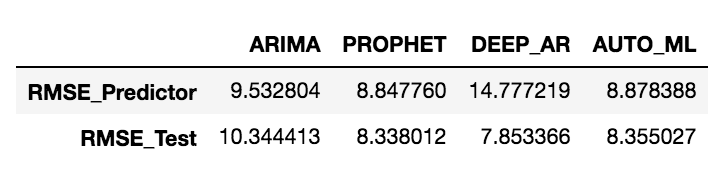

- We observe the absolute sales unit prediction returned by all models and compare it against the true sales values. 
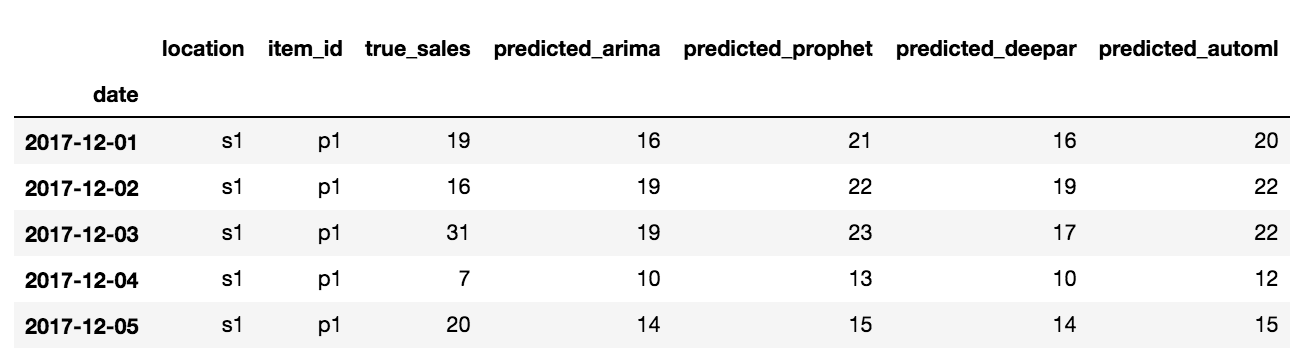

- This is a store wise averaged out sales comparison of true vs predicted values. 
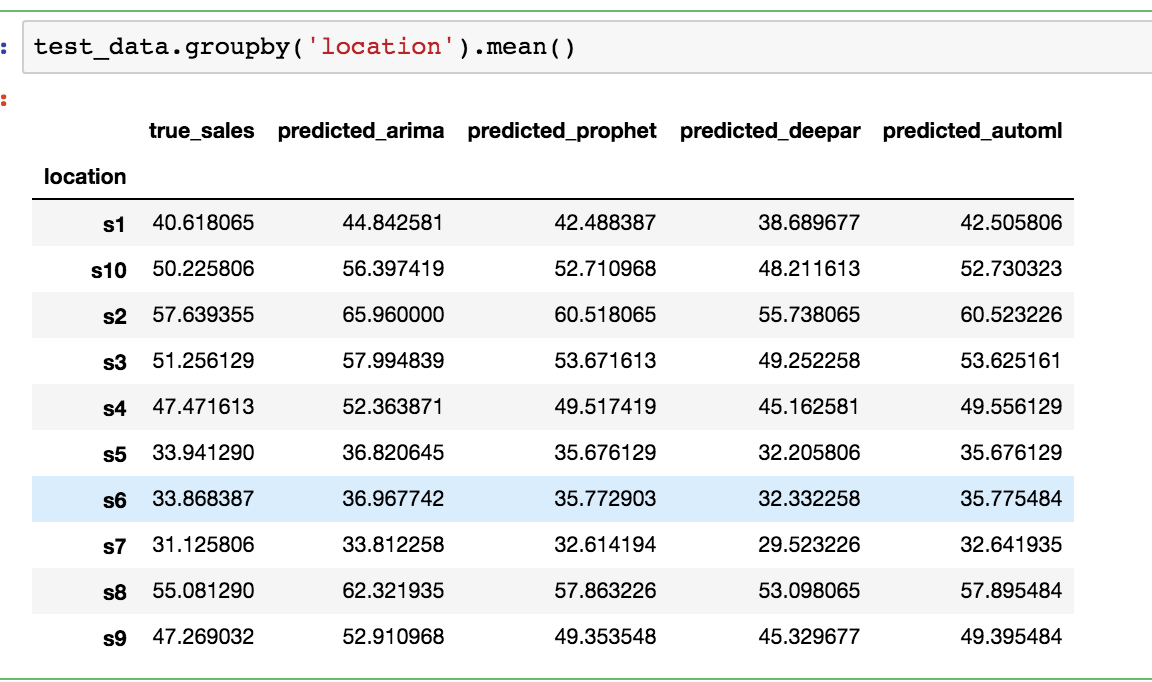

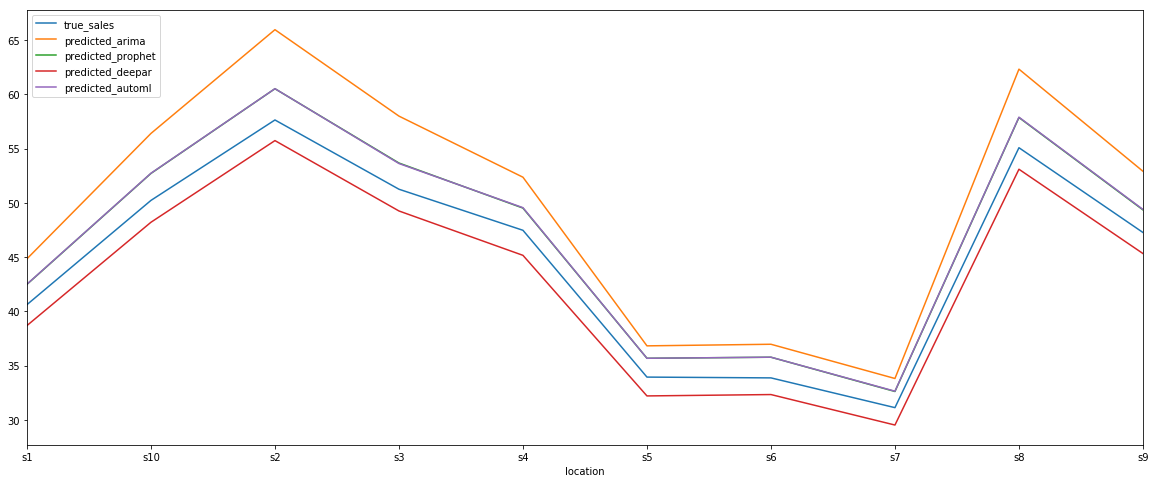

- For our last comparison, we look at the absolute predicted values for the last 10 days of our available data, which is about 20 days ahead in future of our training data. 
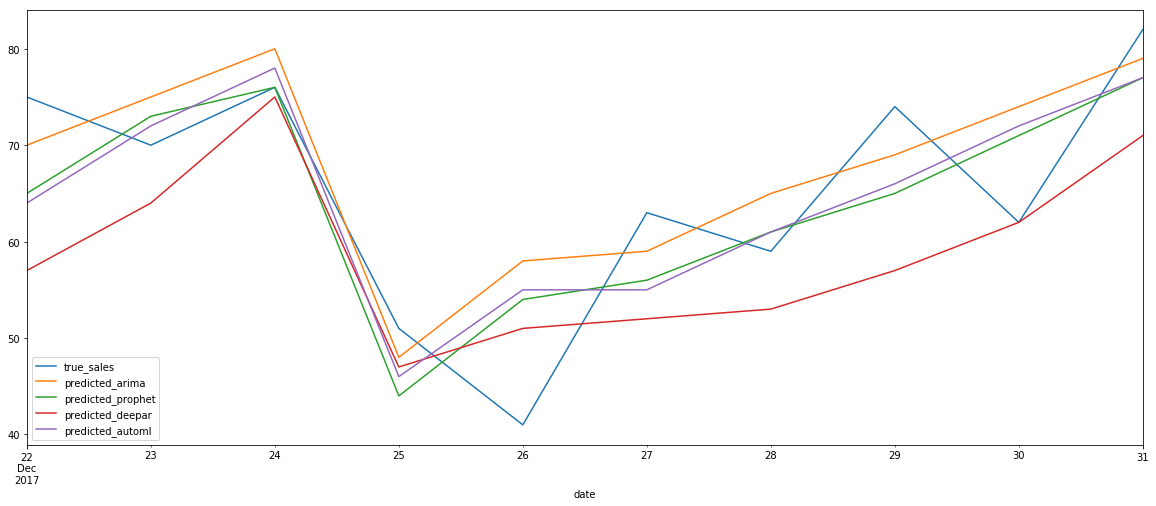


We know it has been a long post, but if you followed the notebook in your AWS account, please do not forget to delete all Forecast related resources as those will incur some cost even when they are not being used. 

Thank you for reading and happy Forecasting! 

In [ ]:
df_rmse.loc['RMSE_Test'] = [rmse_test_arima, rmse_test_prophet, rmse_test_deepar, rmse_test_automl]
df_rmse

In [ ]:
data_frames = [df_arima,df_prophet, df_deepar, df_automl]
for df_ in data_frames:
    test_data = pd.merge(test_data,df_, on=['date', 'item_id', 'location'])


In [ ]:
test_data.head()

In [ ]:
test_data.groupby('location').mean()

In [ ]:
test_data.groupby('location').mean().plot(figsize=(20,8))

In [ ]:
test_data[test_data.columns[2:]].iloc[-10:].plot(figsize=(20,8))

In [ ]:
# Delete Import
forecast.delete_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)
# Delete Dataset Group
forecast.delete_dataset_group(DatasetGroupArn=datasetGroupArn)
# Delete predictor
forecast.delete_predictor(PredictorArn=predictor_arn_arima)
#Delete forecast
forecast.delete_forecast(ForecastArn=forecastArn_arima)
#Delete forecast job 
forecast.delete_forecast_export_job(ForecastExportJobArn=forecastExportJobArn_arima)